# Benchmark adding two 1-D XND arrays

This is a very basic benchmark, intended to get a first impression of XND.
Here we compare three methods to add two 1-D arrays: with `numpy`, with `xnd.array` (which supports the Python `+` operator since recently) and with `gumath`'s `add` gufunc.

In [1]:
import timeit

import numpy as np
import xnd
from gumath import functions as fn

import matplotlib.pyplot as plt

In [2]:
x = np.arange(5)
y = np.ones_like(x)

timeit.timeit('x + y', number=50000, globals=globals())

0.02244636100000008

In [3]:
x2 = xnd.xnd.from_buffer(x)
y2 = xnd.xnd.from_buffer(y)

timeit.timeit('fn.add(x2, y2)', number=10000, globals=globals())

0.021106895999999153

In [4]:
x3 = xnd.array(x.tolist())
y3 = xnd.array(y.tolist())

timeit.timeit('x3 + y3', number=10000, globals=globals())

0.02787825499999741

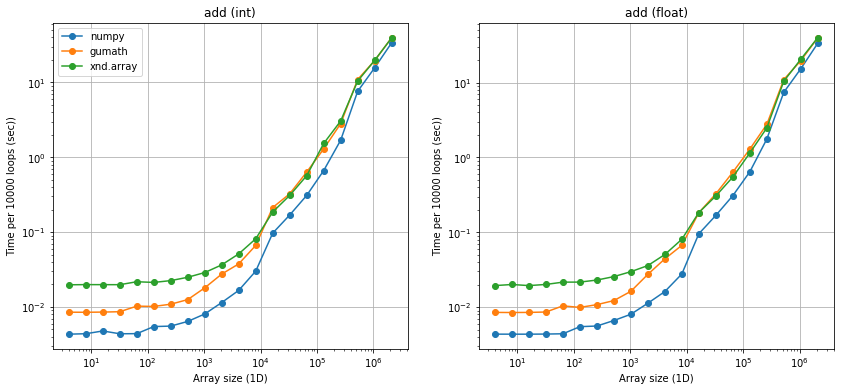

In [5]:
def time_add(size, lib='numpy', dtype=int, n_loops=10000):
    x = np.arange(size, dtype=dtype)
    y = np.ones_like(x)
    if lib == 'numpy':
        expr = 'x + y'
    elif lib == 'gumath':
        x2 = xnd.xnd.from_buffer(x)
        y2 = xnd.xnd.from_buffer(y)
        expr = 'fn.add(x2, y2)'
    elif lib == 'xnd.array':
        x3 = xnd.array(x.tolist())
        y3 = xnd.array(y.tolist())
        expr = 'x3 + y3'   
    else:
        raise ValueError('Unrecognized `lib`: {}'.format(lib))
    
    namespace = locals().copy()
    namespace['fn'] = fn
    # Timeit doesn't figure out number of repetitions automatically,
    # unless used via `python -m timeit`
    div = np.log2(size)
    return div * min(timeit.repeat(expr, number=int(n_loops/div), globals=namespace))


def time_sizes(lib, dtype, n_loops=10000):
    times = []
    for size in sizes:
        times.append(time_add(size, lib=lib, n_loops=n_loops))

    return times 


sizes = 2**np.arange(2, 22)  # 2**16 -> ~65000,  2**22 -> ~4e6
n_loops = 10000

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
for i_ax, dtype in enumerate(['int', 'float']):
    for lib in ('numpy', 'gumath', 'xnd.array'):
        ax[i_ax].loglog(sizes, time_sizes(lib, dtype, n_loops), 'o-', label=lib)

    ax[i_ax].grid(True)
    ax[i_ax].set_xlabel('Array size (1D)')
    ax[i_ax].set_ylabel('Time per {} loops (sec))'.format(n_loops))
    ax[i_ax].set_title('add ({})'.format(dtype))

ax[0].legend(loc='best', numpoints=1)

fig.savefig('benchmark_xnd_add.png')
plt.show()